In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [2]:
class Loss():
    """
        Class to implement the loss functions (functions to calculate the loss)
    """
    def __init__(self):
        pass
    
    def mean_squared_error(self, y, h):
        delta = (y - h)
        error = (np.sum(delta ** 2) * 0.5)
        return error


    def binary_crossentropy(self, y, h):
        if h == 1:
            h -= 1e-9
        if h == 0:
            h += 1e-9
        a = -np.dot(y.T, np.log(h))
        b = -np.dot((1 - y).T, np.log(1 - h))
        return np.sum(a + b)

In [3]:
class Gradient():
    def __init__(self):
        pass
    
    def sigmoid(self, Y):
        """
            Y: input array
            returns gradient output
        """
        return Y*(1-Y)
    
    def relu(self, Y):
        """
            Y: input array
            returns gradient output
        """
        f = lambda x: (1 if x >= 0 else 0)
        return np.array([f(i) for i in Y])
    
    def leakyrelu(self, Y):
        """
            Y: input array
            returns gradient output
        """
        a = 0.01
        f = lambda x: (1 if x >= 0 else a)
        return np.array([f(i) for i in Y])

In [4]:
class Activation():
    def __init__(self):
        pass
    
    def sigmoid(self, X):
        """
        Function to implement sigmoid function

            X: input array
            
            returns:
                sigmoid(X)
        """
        return 1/(1+np.exp(-X))
    
    def relu(self, X):
        """
        Function to implement relu
        
            X: input array
            
            returns:
                relu(X)
        """
        return np.maximum(0, X)
    
    def leaky_relu(self, X):
        """
        Function to implement leaky relu
        
            X: input array
            
            returns:
                leaky relu(x)
        
        """
        a = 0.01
        f = lambda x: (x if x >= 0 else a*x)
        return np.array([f(i) for i in X])

In [5]:
class Layers():
    def __init__(self, units, activation):
        
        """
            Class to implement the neuron layers
        """
        
        grad = Gradient()
        activ = Activation()
        
        self.units = units
        if activation == "sigmoid":
            self.activation = activ.sigmoid
            self.grads = grad.sigmoid
        elif activation == "leaky_relu":
            self.activation = activ.leaky_relu
            self.grads = grad.leakyrelu
        elif activation == "relu":
            self.activation = activ.relu
            self.grads = grad.relu

In [6]:
np.random.seed(42)


class NN:
    """
        Class to implement the model
    """

    def __init__(self, name):
        self.W = []
        self.B = []
        self.layers = []
        self.nLayers = 0
        self.name = name

    def add(self, layer):
        """
        add layer
        """
        self.nLayers += 1
        self.layers.append(layer)
        if self.nLayers > 1:
            n = self.layers[-1].units
            m = self.layers[-2].units
            self.W.append(np.random.random((m, n)))
            self.B.append(np.random.random(n))

    def forward(self, X):
        """
        perform a forward pass
        """
        A, A_prev = [], []
        z = (self.layers[0].activation(X))
        A_prev.append(X)
        A.append(z)
        for i in range(1, self.nLayers):
            a = np.dot(self.W[i - 1].T, z)
            a += self.B[i - 1]
            z = self.layers[i].activation(a)
            A_prev.append(a)
            A.append(z)
        return np.array(z), np.array(A_prev), np.array(A)

    def back_prop(self, pred, Y, A_prev, A, lr):
        """
        back propagation
        """
        
        loss = Loss()
        
        dels, dw, db = [], [], []
        if self.loss == "mean_squared":
            derr = loss.mean_squared_error(Y, pred)
        elif self.loss == "binary_crossentropy":
            derr = loss.binary_crossentropy(Y, pred)
        
        delta = (pred - Y)
        for i in range(self.nLayers - 1, -1, -1):
            if i < (self.nLayers - 1):
                delta = dA * self.layers[i].grads(A_prev[i])
                g = np.outer(delta, A[i + 1])
                dw.append(g)
            if i > 0:
                db.append(delta)
                dA = np.dot(self.W[i - 1], delta)

        dw = np.array(dw[::-1])
        db = np.array(db[::-1])
        
        self.W -= lr * dw
        self.B -= lr * db
        return derr

    def finish(self, loss, epochs, optim='SGD'):
        self.loss = loss
        self.epochs = epochs+1
        self.optim = optim

    def train(self, X_train, Y_train, V=False):
        """
        trains the model
        """
        ep, err = [], []
        for epoch in range(0, self.epochs):
            tot_err = 0.0
            if self.optim == 'SGD':
                i = np.random.randint(0, len(X_train))                
                pred, A_prev, A = self.forward(X_train[i])
                error = self.back_prop(pred=pred, Y=Y_train[i], A_prev=A_prev, A=A, lr = 0.0005)
                if epoch%200==199:
                    tot_err += error
                    if V:
                        print("=====================================")
                        print("epoch {}, loss {}".format(epoch + 1, tot_err))
                        print("=====================================")
                    err.append(tot_err)
                    ep.append(epoch+1)
            else:
                for i in range(0, len(X_train)):
                    pred, A_prev, A = self.forward(X_train[i])
                    error = self.back_prop(pred=pred, Y=Y_train[i], A_prev=A_prev, A=A, lr = 0.0005)
                    tot_err += error
                    
                if epoch%100==99:
                    tot_err /= len(X_train)
                    if V:
                        print("=====================================")
                        print("epoch {}, loss {}".format(epoch + 1, tot_err))
                        print("=====================================")
                    err.append(tot_err)
                    ep.append(epoch+1)
            
        return err, ep

    def predict(self, X_test):
        """
        """
        result = []
        for x in X_test:
            err, _, _ = self.forward(x)
            result.append(err)
        return np.array(result)
    
    
    def print_params(self):
        print("===========================================")
        print("Weights: ")
        for i in self.W:
            print('---------------------------------')
            print(i)
            print('---------------------------------')
            
        print("===========================================")
        print("===========================================")
        for i in self.B:
            print('---------------------------------')
            print(i)
            print('---------------------------------')
        print("===========================================")
        
    def __str__(self):
        return "Neural_Network_{}_{}_Hidden_layers_{}".format(self.name, str(self.nLayers-2), self.optim)

In [7]:
### Utility Functions to plot the data, calculate accuracy and split the dataset

def accuracy(Y_pred, Y_test):
    Y_pred[Y_pred >= 0.5] = 1
    Y_pred[Y_pred < 0.5] = 0
    tp, fp, tn, fn = 0, 0, 0, 0
    
    for (x, y) in zip(Y_pred, Y_test):
        if int(x) == int(y):
            if int(x) == 0:
                tn+=1
            else:
                tp+=1
        else:
            if int(x) == 1:
                fp += 1
            else:
                fn += 1
    
    acc = (tp+tn)/(tp+fp+tn+fn) * 100
    recall = tp/(tp+fn) * 100
    precision = tp/(tp+fp) * 100
    fscore = 2 * (precision*recall)/(precision+recall)
    
    return (acc, fscore)

def plot(err, ep, model):
    
    os.makedirs("plots", exist_ok=True)
    
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.plot(ep, err)
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Error (Loss)")
    plt.title("Loss vs Epochs in SGD "+str(model))
    plt.savefig("./plots/" + str(model)+".png")
    plt.show()

def train_test_split(df, split_ratio, normalize=False, standardize=False):
    for col in df.columns[:-1]:
        if normalize:
            mx = df[col].max()
            mn = df[col].min()
            df[col] = (df[col] - mn) / (mx - mn)
        elif standardize:
            u = df[col].mean()
            sig = df[col].std()
            df[col] = (df[col] - u) / sig

    # generate a split on the data:
    s = int(len(df) * split_ratio)
    xattr = df.columns[:-1]
    yattr = df.columns[-1]
    X = df[xattr][:s]
    Y = df[yattr][:s]
    x = df[xattr][s:]
    y = df[yattr][s:]
    return (np.array(X), np.array(Y), np.array(x), np.array(y))


df = pd.read_csv("housepricedata.csv")
X_train, Y_train, x_test, y_test = train_test_split(df, split_ratio=0.8, standardize=True)

*********  Neural_Network_Relu_1_Hidden_layers_SGD **********


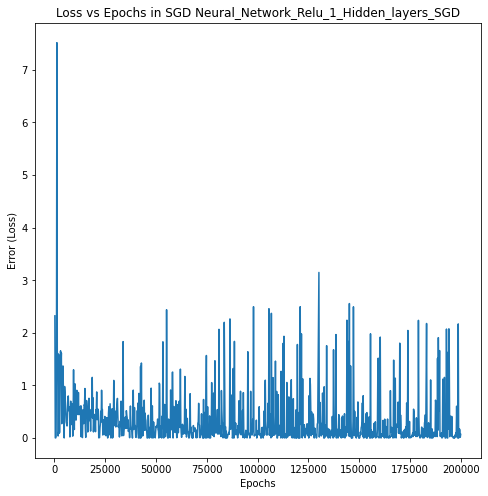

========== Train Statistics ===============
Accuracy:  88.4417808219178  F-Score:  88.47139197267292
========== Test Statistics ===============
Accuracy:  86.98630136986301  F-Score:  86.98630136986301
*********  Neural_Network_Relu_2_Hidden_layers_SGD **********


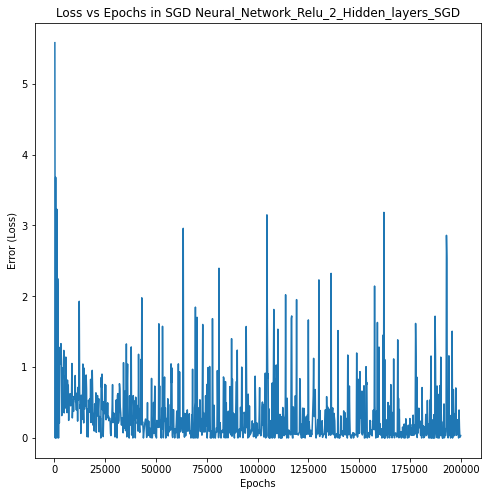

========== Train Statistics ===============
Accuracy:  88.86986301369863  F-Score:  88.8316151202749
========== Test Statistics ===============
Accuracy:  87.32876712328768  F-Score:  87.19723183391004
*********  Neural_Network_Relu_3_Hidden_layers_SGD **********


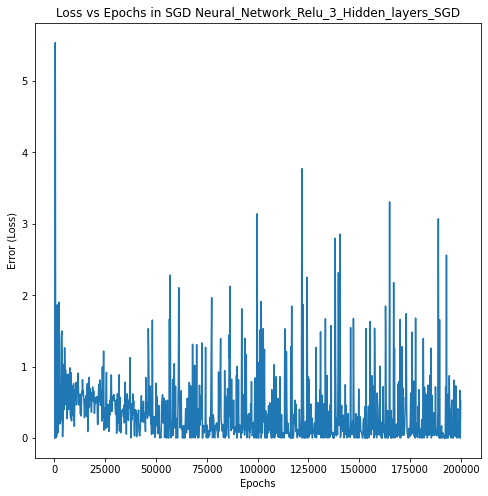

========== Train Statistics ===============
Accuracy:  88.6986301369863  F-Score:  88.85135135135135
========== Test Statistics ===============
Accuracy:  86.3013698630137  F-Score:  86.39455782312926
*********  Neural_Network_Relu_1_Hidden_layers_VGD **********


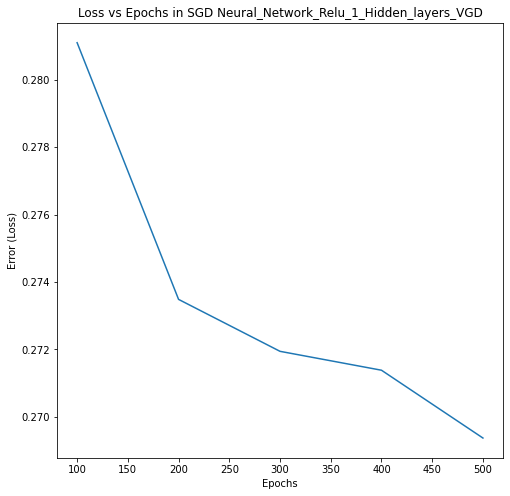

========== Train Statistics ===============
Accuracy:  89.04109589041096  F-Score:  89.05982905982906
========== Test Statistics ===============
Accuracy:  87.67123287671232  F-Score:  87.67123287671232
*********  Neural_Network_Relu_2_Hidden_layers_VGD **********


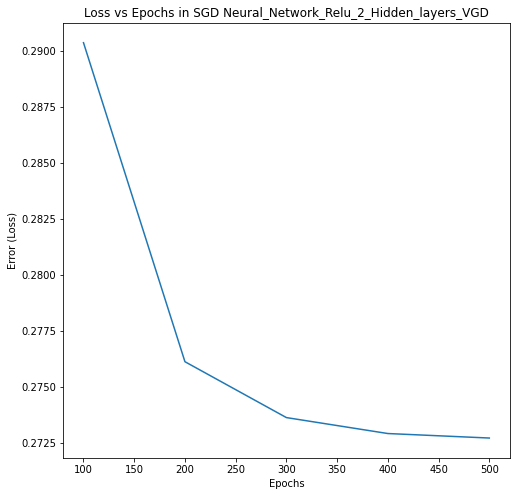

========== Train Statistics ===============
Accuracy:  89.04109589041096  F-Score:  89.05982905982906
========== Test Statistics ===============
Accuracy:  87.67123287671232  F-Score:  87.67123287671232
*********  Neural_Network_Relu_3_Hidden_layers_VGD **********


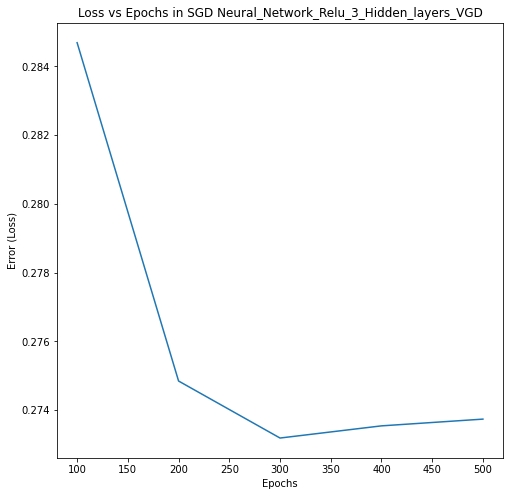

========== Train Statistics ===============
Accuracy:  88.6986301369863  F-Score:  88.62068965517241
========== Test Statistics ===============
Accuracy:  87.32876712328768  F-Score:  87.19723183391004
*********  Neural_Network_Leaky_relu_1_Hidden_layers_SGD **********


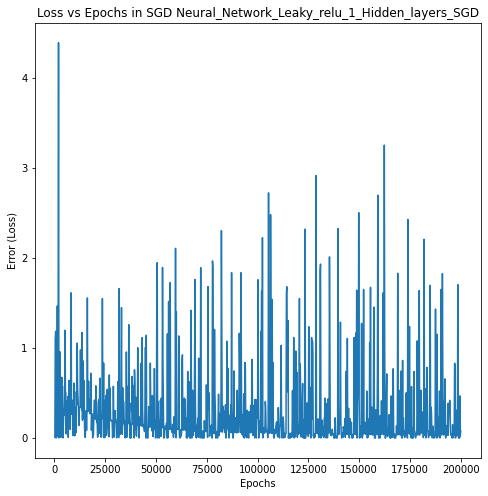

========== Train Statistics ===============
Accuracy:  88.4417808219178  F-Score:  88.47139197267292
========== Test Statistics ===============
Accuracy:  87.32876712328768  F-Score:  87.37201365187713
*********  Neural_Network_Leaky_relu_2_Hidden_layers_SGD **********


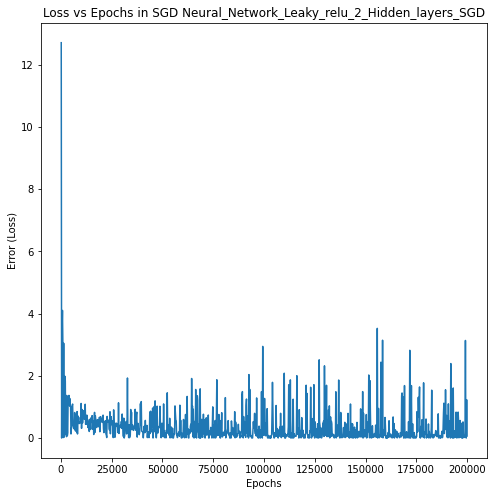

========== Train Statistics ===============
Accuracy:  88.35616438356165  F-Score:  88.37606837606837
========== Test Statistics ===============
Accuracy:  86.98630136986301  F-Score:  86.98630136986301
*********  Neural_Network_Leaky_relu_3_Hidden_layers_SGD **********


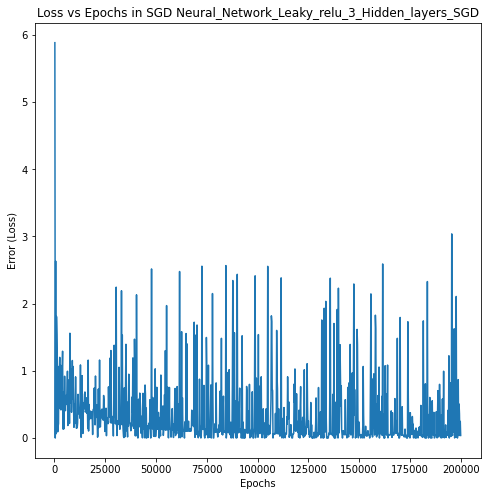

========== Train Statistics ===============
Accuracy:  89.04109589041096  F-Score:  89.29765886287626
========== Test Statistics ===============
Accuracy:  87.32876712328768  F-Score:  87.62541806020067
*********  Neural_Network_Leaky_relu_1_Hidden_layers_VGD **********


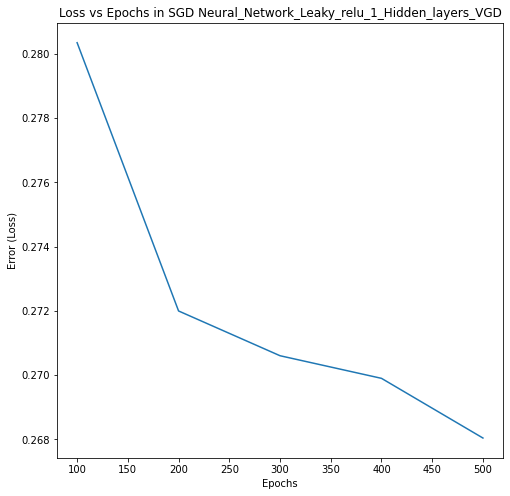

========== Train Statistics ===============
Accuracy:  89.46917808219177  F-Score:  89.49615713065755
========== Test Statistics ===============
Accuracy:  86.98630136986301  F-Score:  86.89655172413794
*********  Neural_Network_Leaky_relu_2_Hidden_layers_VGD **********


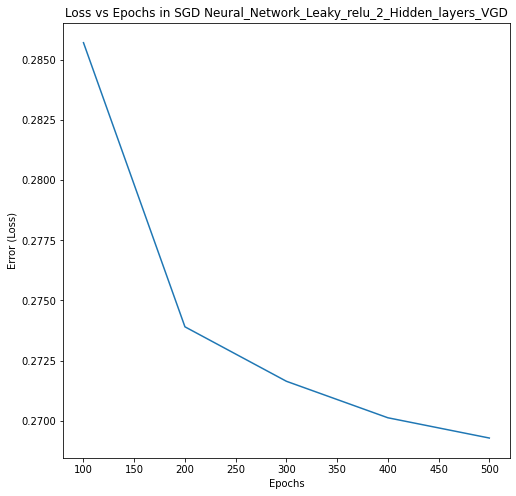

========== Train Statistics ===============
Accuracy:  88.78424657534246  F-Score:  88.7360275150473
========== Test Statistics ===============
Accuracy:  88.01369863013699  F-Score:  88.05460750853243
*********  Neural_Network_Leaky_relu_3_Hidden_layers_VGD **********


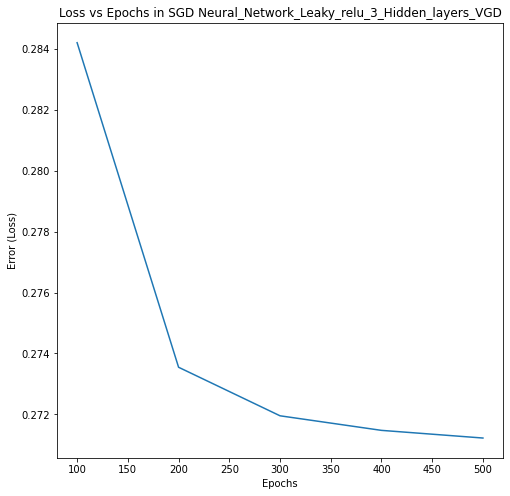

========== Train Statistics ===============
Accuracy:  89.29794520547945  F-Score:  89.28877463581834
========== Test Statistics ===============
Accuracy:  87.32876712328768  F-Score:  87.19723183391004


In [8]:
activation=['relu', 'leaky_relu']
optim = ['SGD', 'VGD']
layer_inputs = [[7], [7, 4], [7, 4, 3]]

for act in activation:
    for opt in optim:
        for layer in layer_inputs:
            model = NN(act.capitalize())
            model.add(Layers(10, act))
            for i in range(len(layer)):
                model.add(Layers(layer[i], act))
            model.add(Layers(1, 'sigmoid'))
            if opt == 'SGD':
                epochs = 200000
            else:
                epochs = 500
            model.finish(loss='binary_crossentropy', epochs=epochs, optim=opt)
            
            print("*********  {} **********".format(str(model)))
            
            err2, ep2 = model.train(X_train, Y_train)
            plot(err2, ep2, model)
            
            print("========== Train Statistics ===============")
            acc, fscore = accuracy(model.predict(X_train), Y_train)
            print("Accuracy: ", acc, " F-Score: ", fscore)
            print("===========================================")
            
            print("========== Test Statistics ===============")
            acc, fscore = accuracy(model.predict(x_test), y_test)
            print("Accuracy: ", acc, " F-Score: ", fscore)
            print("===========================================\n\n")